In [1]:
# Import Needed Modules
import pandas as pd
from dotenv import load_dotenv
import os, time, requests, csv
from datetime import datetime
import numpy as np
from prophet import Prophet
from functions import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib import rcParams
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load Environments, API Key, and variables
load_dotenv('D:/AI/stock_market/.env')
API_KEY = os.getenv("ALPHA_PREM_API_KEY")

# Assign listing_info directory
listing_info_loc = "resources/listing_info.xlsx"

# Check if listing_info.xlsx exists.  If so pull the information, it not, create.
if os.path.exists(listing_info_loc) is False:
    # Run function to pull all listings and return dataframe
    df = get_market_listings(API_KEY)
else:
    # Import file of stock listings
    df = get_listings()

In [57]:
""" 
GATHER TECHNOLOGY STOCKS THAT MEET CRITERIA FOR EXPERT ADVISOR
FACTORS WE HAVE LEARNED INCLUDE: $150 OR ABOVE IN STOCK PRICE AND HIGH VOLATILITY
"""

# Get List of technology stocks
tech = pd.read_excel("resources/technology_industry_list.xlsx")
tech_list = tech['symbol'].tolist()

# Feed list of symbols into function to get company overview data
companies_df = get_company_overview(tech_list, API_KEY)

# Replace Beta-> None with 0.  Beta is Volatility.
companies_df['Beta'].replace('None', 0, inplace=True)

# Set 200 Day Moving Average and Beta to float type
companies_df = companies_df.astype({"200DayMovingAverage":float, "Beta":float})

# Keep only company listings that have greater or equal to $150 stock price
# within the 200 Day Moving Average.  Return only the symbol, Beta, and 200 DMA
vol_companies_df = companies_df.loc[companies_df['200DayMovingAverage'] >= 150][['Symbol','Beta','200DayMovingAverage']].reset_index(drop=True)

# Sort the companies by Beta "Volatility" in descending order and keep only the
# top 20 to pick from.
vol_companies_df = vol_companies_df.sort_values("Beta", ascending=False)
vol_companies_df.head(20)

,Symbol,Beta,200DayMovingAverage
43,MSTR,2.617,445.83
46,ZBRA,1.776,255.60
67,ACLS,1.688,150.58
2,NVDA,1.684,484.29
33,HUBS,1.607,522.03
55,WEX,1.597,189.58
22,NXPI,1.578,205.33
64,NSIT,1.549,156.86
59,OLED,1.512,160.52
12,LRCX,1.504,696.96


In [58]:
""" 
PROCESS TOP 20 TECHNOLOGY STOCKS TO PREDICT VOLATILITY FOR EA DEPLOYMENT.
THIS SECTION USES PROPHET THROUGH A FUNCTION TO PREDICT WHEN THE NEXT VOLATILITY
WILL BE HIGH WITH EACH STOCK SYMBOL FOR BEST DEPLOYMENT OF EA.  THIS WILL SAVE
COMPONENT CHARTS AND YHAT CHART FOR EACH SYMBOL IN THEIR OWN FOLDER FOR QUICK
VISUAL ANALYSIS.
"""
for index, row in vol_companies_df[:20].iterrows():
    symbol = row['Symbol']

    # Create folder in charts to house each stock chart
    folder = f'charts/{symbol}'
    os.makedirs(folder, exist_ok=True)
    
    # Pull stock data
    # Since we are taking the top 20, it remains under 30 per min API request
    df_stock, df_daily = get_daily_series([symbol], API_KEY)

    # Run forecast for stocks on next trading day
    forecast, forecast_range = prediction_series(df_stock, 'volatility_diff', 288)

    # Get chart for components
    components = forecast_range.reset_index(drop=True).plot(x='ds', 
                                                            xlabel='Time of Day', 
                                                            ylabel="Volatility", 
                                                            figsize=[10,6],
                                                            title=f"Forecast Volatility Times ({symbol})")
    
    # Save chart and close figure
    components.figure.savefig(f'{folder}/{symbol}_forecast_upper_lower.jpg')
    plt.close(components.figure)

    # Get chart for yhat only
    yhat_component = forecast_range[['ds','yhat']].reset_index(drop=True).plot(x='ds', 
                                                            xlabel='Time of Day', 
                                                            ylabel="Volatility",
                                                            figsize=[10,6], 
                                                            title=f"yhat Only Forecast Volatility Times ({symbol})")

    # Save chart and close figure
    yhat_component.figure.savefig(f'{folder}/{symbol}_forecast_yhat.jpg')
    plt.close(yhat_component.figure)

03:21:15 - cmdstanpy - INFO - Chain [1] start processing
03:21:16 - cmdstanpy - INFO - Chain [1] done processing
03:21:20 - cmdstanpy - INFO - Chain [1] start processing
03:21:20 - cmdstanpy - INFO - Chain [1] done processing
03:21:25 - cmdstanpy - INFO - Chain [1] start processing
03:21:25 - cmdstanpy - INFO - Chain [1] done processing
03:21:30 - cmdstanpy - INFO - Chain [1] start processing
03:21:31 - cmdstanpy - INFO - Chain [1] done processing
03:21:35 - cmdstanpy - INFO - Chain [1] start processing
03:21:35 - cmdstanpy - INFO - Chain [1] done processing
03:21:39 - cmdstanpy - INFO - Chain [1] start processing
03:21:40 - cmdstanpy - INFO - Chain [1] done processing
03:21:45 - cmdstanpy - INFO - Chain [1] start processing
03:21:45 - cmdstanpy - INFO - Chain [1] done processing
03:21:50 - cmdstanpy - INFO - Chain [1] start processing
03:21:50 - cmdstanpy - INFO - Chain [1] done processing
03:21:54 - cmdstanpy - INFO - Chain [1] start processing
03:21:54 - cmdstanpy - INFO - Chain [1]

In [59]:
"""
EXPERT ADVISOR RESULTS ARE EXPORTED INTO AN HTML FORMAT AND ADDED TO resources/html
WHICH THEN GETS PULLED INTO HERE.  THIS SECTION READS ALL HTML FILES IN THE FOLDER
AND CONCATENATES THEM INTO A DATAFRAME FOR ANALYSIS.
"""
# Create list of html files in the html folder: Does not weed out non-html
html_pages = os.listdir("resources/html")

# Create DataFrame to concat to
compiled_df = pd.DataFrame()

# Loop through html_pages list to pull in
for page in html_pages:

    # Read in the file using pandas
    # Render the 3rd row as data header skipping the first two rows
    df = pd.read_html(f"resources/html/{page}", header=2)
    
    # Pull the first Table which is the only table in the html page
    data_df = pd.DataFrame(df[0])

    # Convert Ticket to numeric and coerce the rest to NaN
    data_df['Ticket'] = pd.to_numeric(data_df['Ticket'], errors="coerce")

    # Keep only that of Ticket and Size that is not null
    # This keeps trade data then removes the first row of balance
    data_df = data_df[(pd.notnull(data_df['Ticket'])) & (pd.notnull(data_df['Size']))]
    compiled_df = pd.concat([compiled_df, data_df], axis="rows")

# Convert Profit to numeric and force NaN as needed
compiled_df.loc[:, 'Profit'] = pd.to_numeric(compiled_df['Profit'], errors='coerce')


In [60]:
""" 
TALLEY UP THE DATA TO PROVIDE PROFIT, STRIKERATE, AVG WIN, & AVG LOSS 
When providing the prompt: "Can you teach me how to optimize the following code:
results_profit = compiled_df.groupby("Item").agg({"Profit":"sum"})
results_strikerate = compiled_df.groupby("Item")["Profit"].apply(lambda x: (x>0).mean())

# Get the average wins and loss
avg_win = compiled_df.loc[compiled_df['Profit'] > 0].groupby("Item").agg({"Profit":"mean"})
avg_loss = compiled_df.loc[compiled_df['Profit'] < 0].groupby("Item").agg({"Profit":"mean"})

# Merge the data
results = pd.merge(results_profit, results_strikerate, on="Item")
results = results.rename(columns={"Profit_x":"Profits","Profit_y":"Strikerate"})
results = pd.merge(results, avg_win, on="Item")
results = pd.merge(results, avg_loss, on="Item")
results = results.rename(columns={"Profit_x":"Average Win","Profit_y":"Average Loss"})
" GPT suggested integrating each aggregate into a singular grouby. (OpenAI, 2024)
"""
results = (
    compiled_df.groupby("Item").agg(
                                Profit=("Profit", "sum"),
                                # Calculate the number of wins to the number of trades
                                Strikerate=("Profit", lambda x: (x > 0).mean()),
                                # Use boolean mask [] to filter out true statements
                                # Calculate the mean of only greater than 0
                                AverageWin=("Profit", lambda x: x[x > 0].mean()),
                                # Calculate the mean of only less than 0
                                AverageLoss=("Profit", lambda x: x[x < 0].mean()),
    )
) # (OpenAI, 2024)

results = results.dropna()
results = results.rename(columns={"AverageWin":"Average Win",
                                  "AverageLoss":"Average Loss"})
results = results.T
results

Item,aapl,dj30.p,googl,nvda,xauusd,ymh24
Profit,-17.9,7766.0,-13.6,-1209.2,-19.0,-1480.0
Strikerate,0.317073,0.24359,0.454545,0.010753,0.45,0.084507
Average Win,0.346154,240.526316,0.4,1.75,0.718519,15.0
Average Loss,-0.933333,-34.358382,-1.306667,-6.590761,-1.23871,-24.920635


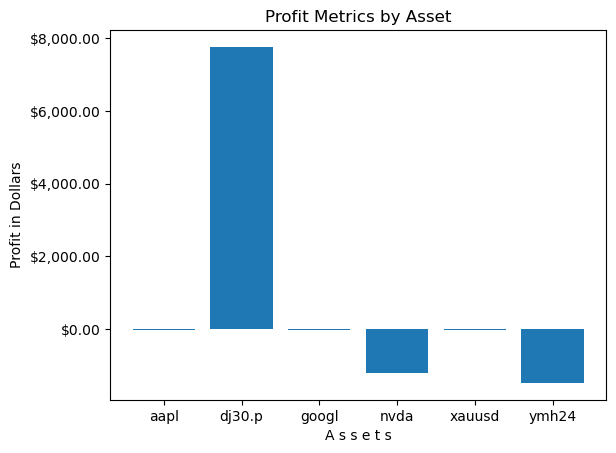

In [61]:
"""
PREPARE THE RESULTED TALLEY DATA AND BEGIN GRAPHING THE RESULTS
"""
# Pull the assets (companies) and the profit for each
assets = results.columns.to_list()
profit = results.iloc[0].to_list()
strike_rate = results.iloc[1].to_list()
average_win = results.iloc[2].to_list()
average_loss = results.iloc[3].to_list()

# Graph Metrics by Asset
# Plot the DataFrame
plt.bar(assets, profit)
plt.title('Profit Metrics by Asset')
plt.xlabel('A s s e t s')
plt.ylabel('Profit in Dollars')
# Rotate the labels
plt.xticks(rotation='horizontal')

# Format y ticks with dollar sign
axes = plt.gca()
formatter = FuncFormatter(lambda y, pos: '${:,.2f}'.format(y))
axes.yaxis.set_major_formatter(formatter)

plt.show()

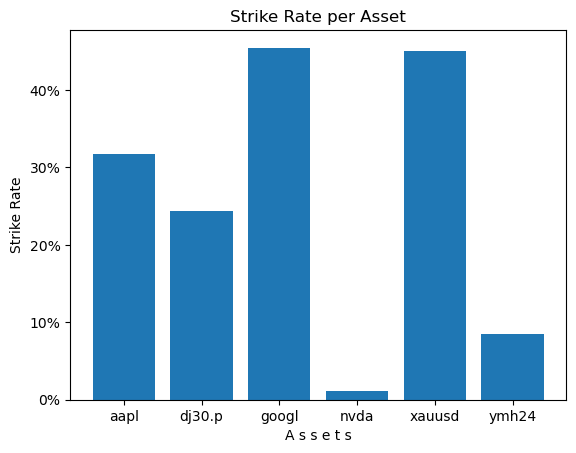

In [62]:
# Graph Strikerate by asset
# Create the plot
plt.bar(assets, strike_rate)

# Add title and labels
plt.title('Strike Rate per Asset')
plt.xlabel('A s s e t s')
plt.ylabel('Strike Rate')

# Format y ticks with percentage sign
axes = plt.gca()
formatter = FuncFormatter(lambda y, pos: '{:,.0f}%'.format(y * 100))  # Multiply by 100 for percentage
axes.yaxis.set_major_formatter(formatter)

# Show the plot
plt.show()

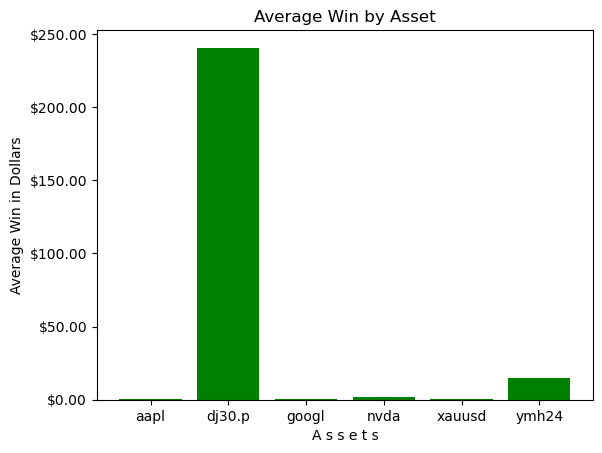

In [63]:
# Graph average win by asset
plt.bar(assets, average_win, color='green')

# Add labels and title
plt.xlabel('A s s e t s')
plt.ylabel('Average Win in Dollars')
plt.title('Average Win by Asset')

# Rotate the labels
plt.xticks(rotation='horizontal')

# Format y ticks with dollar sign
axes = plt.gca()
formatter = FuncFormatter(lambda y, pos: '${:,.2f}'.format(y))
axes.yaxis.set_major_formatter(formatter)

# Show the plot
plt.show()

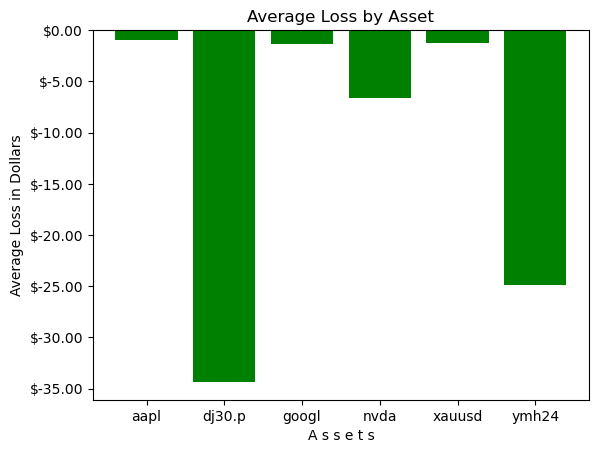

In [64]:
# Graph average loss by asset
plt.bar(assets, average_loss, color='green')
# Add labels and title
plt.xlabel('A s s e t s')
plt.ylabel('Average Loss in Dollars')
plt.title('Average Loss by Asset')
# Rotate the labels
plt.xticks(rotation='horizontal')

# Format y ticks with dollar sign
axes = plt.gca()
formatter = FuncFormatter(lambda y, pos: '${:,.2f}'.format(y))
axes.yaxis.set_major_formatter(formatter)

# Show the plot
plt.show()

In [2]:
""" 
USE MACHINE LEARNING TO ANALYZE THE DOW JONES
"""
# List of symbols in the Dow Jones
dj_symbols = ['MMM','AXP','AMGN','AAPL','BA','CAT','CVX','CSCO','KO','DIS','DOW',
          'GS','HD','HON','IBM','INTC','JNJ','JPM','MCD','MRK','MSFT','NKE',
          'PG','CRM','TRV','UNH','V','WBA','WMT']

# Get Daily Series for Stocks
get_daily_series(dj_symbols, API_KEY)

# Get Company Overview for Dow Jones Companies
companies_df = get_company_overview(dj_symbols, API_KEY)

In [3]:
# Format the Company Data
df_stock = companies_df.copy()

# Remove Columns not needed
df_stock = df_stock.drop(columns=['DividendDate', 'ExDividendDate', 'Industry', 
                                  'Address', 'Name', 'Description','LatestQuarter',
                                  'Currency','Country','FiscalYearEnd','AssetType','CIK'])

# Set Symbol as the index
df_stock = df_stock.set_index("Symbol")

In [4]:
# Make column list of DataFrame
column_list = df_stock.columns.to_list()

# List non numeric columns
not_numeric = ['Exchange','Sector']

# Create list for only to_numeric application
make_numeric = [x for x in column_list if x not in not_numeric]

# Make only numeric columns numeric
df_stock[make_numeric] = df_stock[make_numeric].apply(pd.to_numeric, errors="coerce")

In [5]:
""" TIME TO SCALE THE DATA AND CLUSTER """

stock_data_scaled = StandardScaler().fit_transform(df_stock[make_numeric])

# Select columns that are not in not_numeric and use get_dummies
sector_encoded_df = pd.get_dummies(df_stock['Sector'])
exchange_encoded_df = pd.get_dummies(df_stock['Exchange'])

# Create a DataFrame with scaled data and set the Symbol as index
stocks_scaled = pd.DataFrame(stock_data_scaled, columns=make_numeric).set_index(df_stock.index)

# Concat the data together for clustering
df_stocks_scaled = pd.concat([stocks_scaled, sector_encoded_df, exchange_encoded_df], axis=1)

# Format scaled data for NaN and replace True False with 1, 0
df_stocks_scaled = df_stocks_scaled.fillna(0)
df_stocks_scaled = df_stocks_scaled.replace(True,1)
df_stocks_scaled = df_stocks_scaled.replace(False,0)

In [6]:
# Create the clustering with 3 clusters
model = KMeans(n_clusters=3, n_init='auto')

# Fit the model
model.fit(df_stocks_scaled)

# Make a copy of df_stocks_scaled for prediction
stocks_scaled_predictions = df_stocks_scaled.copy()

# Predict the model segments (clusters)
stock_clusters = model.predict(stocks_scaled_predictions)

# Create a new column for prediction clusters
stocks_scaled_predictions["Clusters"] = stock_clusters

# Review the DataFrame
stocks_scaled_predictions.head()

c:\Users\James\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendPerShare,DividendYield,EPS,RevenuePerShareTTM,ProfitMargin,...,SharesOutstanding,ENERGY & TRANSPORTATION,FINANCE,LIFE SCIENCES,MANUFACTURING,TECHNOLOGY,TRADE & SERVICES,NASDAQ,NYSE,Clusters
Symbol,,,,,,,,,,,,,,,,,,,,,
MMM,-0.537432,-0.544543,0.000000,-0.112948,-0.521041,0.751401,2.902970,-2.554504,-0.241444,-2.404375,...,-0.598047,0,0,1,0,0,0,0,1,2
AXP,-0.382439,0.000000,-0.271675,-0.547998,-0.022804,-0.597250,-0.951793,0.486933,-0.026744,0.010701,...,-0.543448,0,1,0,0,0,0,0,1,2
AMGN,-0.395000,-0.402400,-0.254566,-0.127585,-0.472392,1.695456,0.536749,0.650300,-0.322859,0.586349,...,-0.603399,0,0,1,0,0,0,1,0,1
AAPL,3.362685,3.436967,-0.221670,0.017161,-0.585691,-1.140456,-1.344993,-0.121865,-0.684649,0.745148,...,4.151232,0,0,0,0,1,0,1,0,0
BA,-0.435393,-0.698184,0.000000,3.528466,-1.132792,0.000000,0.000000,-1.412210,0.654128,-1.177649,...,-0.579726,0,0,0,1,0,0,0,1,2


<Axes: xlabel='50DayMovingAverage', ylabel='PriceToSalesRatioTTM'>

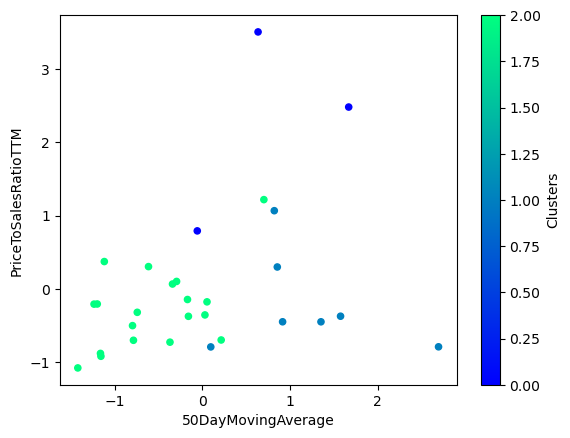

In [18]:
# Make scatter plot
stocks_scaled_predictions.plot.scatter(
    x="50DayMovingAverage",
    y="PriceToSalesRatioTTM",
    c="Clusters",
    colormap='winter')